In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from lifelines import KaplanMeierFitter,CoxPHFitter, WeibullAFTFitter, NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts

In [11]:
df=pd.read_csv("Telco-Customer-Churn.csv")


df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:

## Data Types 

df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:

#Convert text data to numeric values

## TotalCharges 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.

df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )


df.info()  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Column TotalCharges is having missing values. We need to either impute missing numbers or drop them


In [14]:

## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


Lot of data is categorical (Yes, No). We want to see the list of catrgoriacal colums. 

But customer id is not a categorical as it changes with each customer. So we remove it
 

In [15]:

cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')


In [16]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-----------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-----------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-----------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
-----------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
-----------------------------
Column Name:  OnlineBackup
No                     3088
Yes     

<AxesSubplot:xlabel='timeline'>

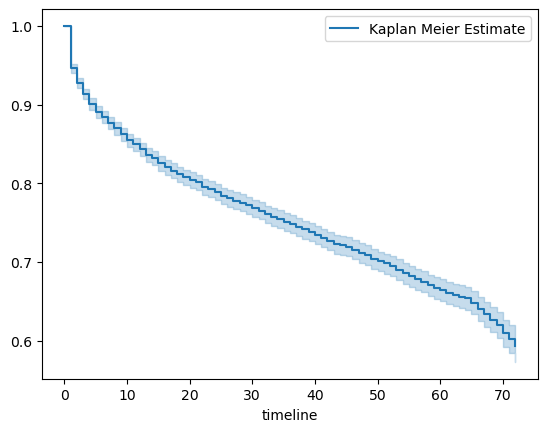

In [17]:
## Lets create an overall KaplanMeier curve

## Import the library
from lifelines import KaplanMeierFitter


durations = df['tenure'] ## Time to event data of censored and event data
event_observed = df['Churn']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

survival probability goes down almost linearly

now we can generate survival probabilities and KM curve across different groups. We look at contract - where there monthly, one year and  two year contract

<AxesSubplot:xlabel='timeline'>

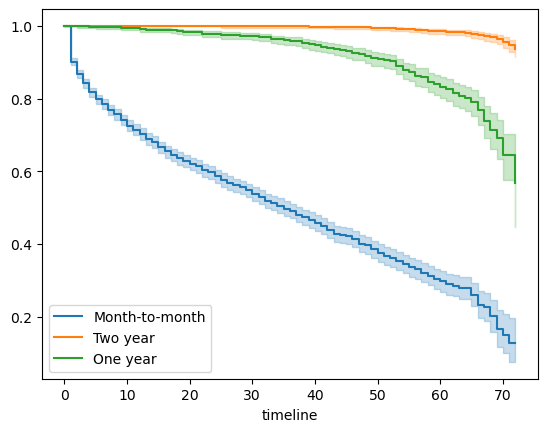

In [18]:
##KM for cohorts

kmf = KaplanMeierFitter() 


T = df['tenure']     ## time to event
E = df['Churn']      ## event occurred or censored


groups = df['Contract']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'Month-to-month')   ## Cohort 1
ix2 = (groups == 'Two year')         ## Cohort 2
ix3 = (groups == 'One year')         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Month-to-month')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Two year')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='One year')        ## fit the cohort 3 data

kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis



Not surprisingly,  month to month contact leads to more churn.  In 30 months time, 50% of people have quit in month to month contract. Two year contract leads to very little churn. 

Now we compare cohorts who subscribe to streaming TV vs those who do not

<AxesSubplot:xlabel='timeline'>

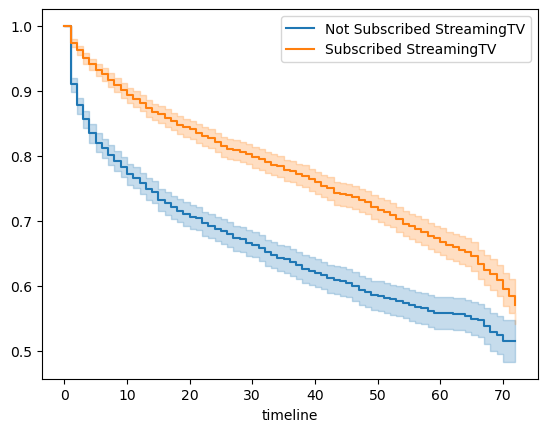

In [19]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.groups = df['StreamingTV']   
groups = df['StreamingTV']
i1 = (groups == 'No')      ## group i1 , having the pandas series  for the 1st cohort
i2 = (groups == 'Yes')     ## group i2 , having the pandas series  for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

People who suscribe to streaming leads to less churn

We can combine this cohort with the contract cohort which will give us 6 segments and lead to 6 survival curves. Of course we donot know the size of each segment to trust such curves 

We can first plot the histogram of how the survival looks in our data. We plot only for users who go through the event.

To incorporte more cohorts, we have rely on Cox Proportional Hazard Model (Survival Regression). First we have to choose what covariates we want.

In [20]:
from lifelines import CoxPHFitter     


Only using the subset of the columns present in the original data as covariates


In [21]:
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data 


,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [22]:
## We want to convert text (Yes, no) data to generate Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True) #remember streaming TV is not a binary variable so we can not estimate all 3 choices there
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [23]:

# Using Cox Proportional Hazards model

cph = CoxPHFitter()   ## Instantiate the class to create a cph object

cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model

cph.print_summary()    ## HAve a look at the significance of the features



<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2024-02-02 16:48:50 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40                 0.50
Dependents_Yes                   -0.36       0.70       0.07            -0.49            -0.22                 0.61                 0.80
PhoneService_Yes                  0.69       2.00       0.10             0.49             0.90                 1.63                 2.45
StreamingTV_No internet service  -2.10       0.12       0.13            -2.36            -1.84                 0.09                 0.16
StreamingTV_Yes                  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                                  cmp to      z      p   -log2(p)
covariate                                                        
MonthlyCharges                      0.00  -6.13 <0.005      30.06
SeniorCitizen                       0.00   7.16 <0.005      40.15
gender_Male                         0.00  -0.23   0.82       0.29
Partner_Yes                         0.00 -14.93 <0.005     164.98
Dependents_Yes                      0.00  -5.21 <0.005      22.37
PhoneService_Yes                    0.00   6.65 <0.005      34.96
StreamingTV_No internet service     0.00 -15.79 <0.005     184.09
StreamingTV_Yes                     0.00  -3.10 <0.005       9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

<AxesSubplot:xlabel='log(HR) (95% CI)'>

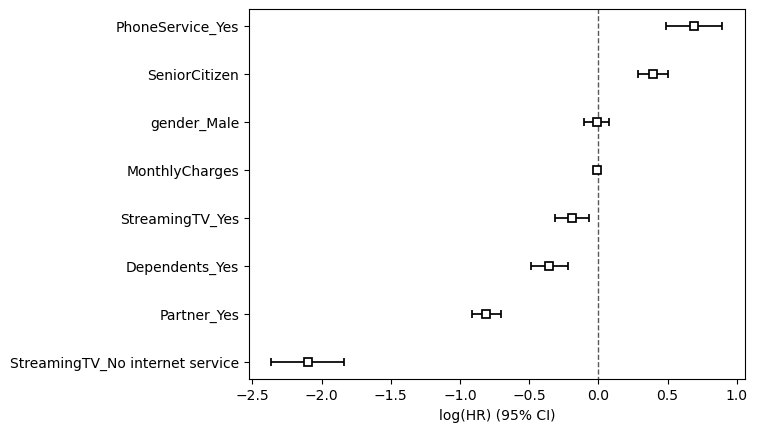

In [24]:
cph.plot()

If we want to see the Survival curve at the customer level we can do that. Lets select 6 customers (rows 5 till 9).

In [25]:

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows


,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


<AxesSubplot:>

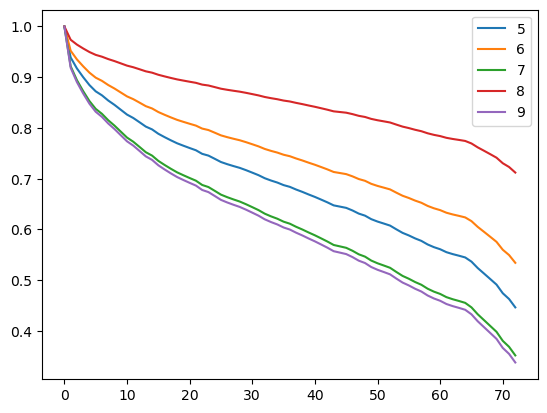

In [26]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.

cph.predict_survival_function(tr_rows).plot()



Marginal efect of covariates. Here we have all dummies except monthly charge. We can see how it affects survival, though notice that monthly charge is not significant. Thefore, we may be not be interested in its margial effect.

<AxesSubplot:>

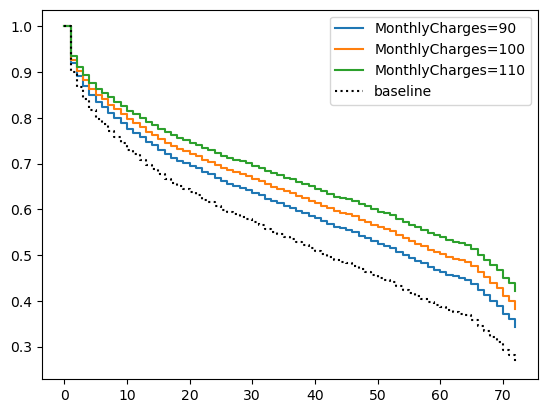

In [27]:
cph.plot_partial_effects_on_outcome(covariates = 'MonthlyCharges', values = [90, 100, 110])

We use following dataset to account for time varying covariates and test some assumptions of Cox

In [ ]:
#cph.predict_survival_function(dt_TV)

In [53]:

dataTV = pd.read_csv("time_varying.csv")
from lifelines import CoxPHFitter

The data is about the recidivism rate of 432 prisoners. The attaributes are as follows

In [54]:
dt_TV= dataTV.loc[:,['week','arrest','fin','age','race','wexp','mar','paro','prio']]
dt_TV.head(5)

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [55]:
cph = CoxPHFitter()

cph.fit(dt_TV, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [56]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.748
         time fit was run = 2024-02-02 19:27:27 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin       -0.379      0.684      0.191           -0.755           -0.004                0.470                0.996
age       -0.057      0.944      0.022           -0.101           -0.014                0.904                0.986
race       0.314      1.369      0.308           -0.290            0.918                0.748                2.503
wexp      -0.150      0.861      0.212           -0.566            0.266                0.568                1.305
mar       -0.434      0.648      0.382           -1.182            0.315                0.307                1.370
paro      -0.085      0.919      0.196           -0.469            0.299                0.626                1.348
prio       0.091      1.096      0.029            0.035            0.148                1.036                1.159

            cmp to      z     p   -log2(p)
covariate                                 
fin          0.000 -1.983 0.047      4.398
age          0.000 -2.611 0.009      6.791
race         0.000  1.019 0.308      1.698
wexp         0.000 -0.706 0.480      1.058
mar          0.000 -1.136 0.256      1.965
paro         0.000 -0.434 0.665      0.589
prio         0.000  3.194 0.001      9.476
---
Concordance = 0.640
Partial AIC = 1331.495
log-likelihood ratio test = 33.266 on 7 df
-log2(p) of ll-ratio test = 15.370

In [59]:
# we can predict survival function
#cph.predict_survival_function(dt_TV)

age is significant. A unit increase in age reduces the hazard of recidivim by 6%. We now test the assumption of proportionality 

In [60]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, dt_TV)
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic      p  -log2(p)
age            11.45 <0.005     10.45
fin             0.02   0.90      0.15
mar             0.71   0.40      1.32
paro            0.13   0.71      0.49
prio            0.02   0.89      0.17
race            1.43   0.23      2.11
wexp            7.31   0.01      7.19



Alternatively you can test the assumptions this way

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0007)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0009)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0068)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0063)'>]]

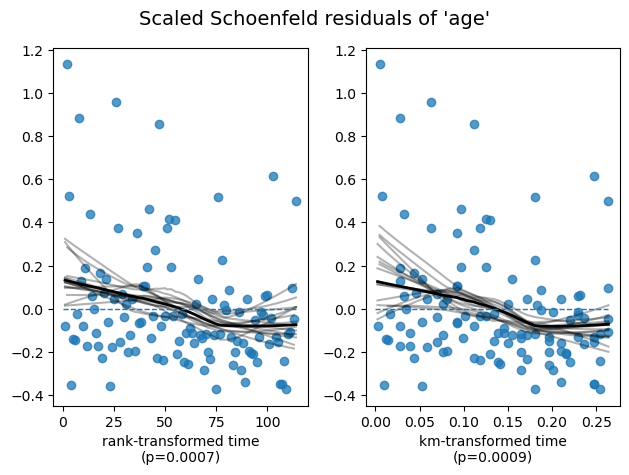

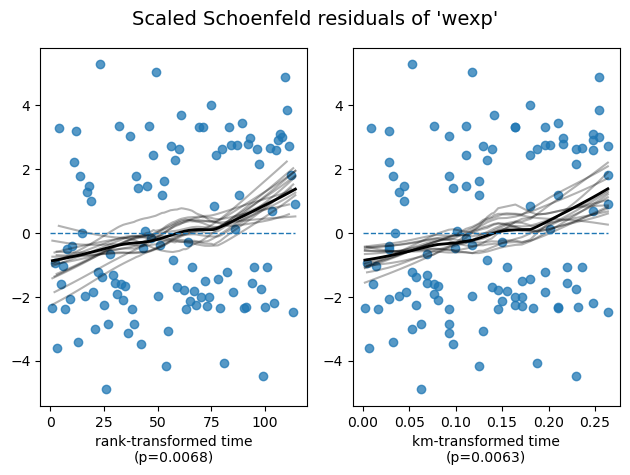

In [61]:
cph.check_assumptions(dt_TV, p_value_threshold=0.05,  show_plots = True) 


Age and Wexp are violating proportionality assumption. The command provide following suggestion..

2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.
   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`

In [63]:
cph.fit(dt_TV, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="wexp in strata")

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = wexp
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -580.89
         time fit was run = 2024-02-02 19:58:08 UTC
                    model = wexp in strata

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.76            -0.01                 0.47                 0.99
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.36       0.31            -0.30             0.91                 0.74                 2.49
mar        -0.45       0.64       0.38            -1.20             0.29                 0.30                 1.34
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.09       0.03             0.03             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.99   0.05       4.42
age           0.00 -2.64   0.01       6.91
race          0.00  1.00   0.32       1.65
mar           0.00 -1.19   0.23       2.09
paro          0.00 -0.42   0.67       0.57
prio          0.00  3.16 <0.005       9.33
---
Concordance = 0.61
Partial AIC = 1173.77
log-likelihood ratio test = 23.77 on 6 df
-log2(p) of ll-ratio test = 10.77

To account for violation of proportionality of age, 
"2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`

we treat age as a time varying covariate and we allow age to change with time. See slides for the intuition

In [64]:
from lifelines.utils import to_episodic_format

# the time_gaps parameter specifies how large or small you want the periods to be.
dt_TV_long = to_episodic_format(dt_TV, duration_col='week', event_col='arrest', time_gaps=1.)
dt_TV_long.describe()

,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
count,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000,19809.000000
mean,25.171336,24.171336,0.005755,24.764703,0.511131,214.255036,0.131960,0.621839,2.841284,0.871523,0.596093
std,14.927616,14.927616,0.075645,6.134425,0.499889,124.542338,0.338456,0.484940,2.699501,0.334629,0.490692
min,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,11.000000,0.000000,20.000000,0.000000,107.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,25.000000,24.000000,0.000000,23.000000,1.000000,213.000000,0.000000,1.000000,2.000000,1.000000,1.000000
75%,38.000000,37.000000,0.000000,27.000000,1.000000,323.000000,0.000000,1.000000,4.000000,1.000000,1.000000
max,52.000000,51.000000,1.000000,44.000000,1.000000,431.000000,1.000000,1.000000,18.000000,1.000000,1.000000


In [39]:
dt_TV_long.head(30)

,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


we create a new variable (time varying covariate) where age is now changin with time

In [40]:
dt_TV_long['time*age'] = dt_TV_long['age'] * dt_TV_long['stop']

In [45]:
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

ctv.fit(dt_TV_long,
        id_col='id',
        event_col='arrest',
        start_col='start',
        stop_col='stop',
        strata=['wexp']
       )

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>

In [46]:
ctv.print_summary(3, model="age * time interaction")

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>
         event col = 'arrest'
            strata = wexp
number of subjects = 432
 number of periods = 19809
  number of events = 114
partial log-likelihood = -575.080
  time fit was run = 2024-02-02 18:18:20 UTC
             model = age * time interaction

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        0.073      1.075      0.040           -0.005            0.151                0.995                1.163
fin       -0.386      0.680      0.191           -0.760           -0.011                0.468                0.989
mar       -0.397      0.672      0.382           -1.147            0.352                0.318                1.422
paro      -0.098      0.907      0.196           -0.481            0.285                0.618                1.330
prio       0.090      1.094      0.029            0.034            0.146                1.035                1.158
race       0.295      1.343      0.308           -0.310            0.899                0.733                2.458
time*age  -0.005      0.995      0.002           -0.008           -0.002                0.992                0.998

            cmp to      z     p   -log2(p)
covariate                                 
age          0.000  1.830 0.067      3.893
fin          0.000 -2.018 0.044      4.520
mar          0.000 -1.039 0.299      1.743
paro         0.000 -0.501 0.616      0.698
prio         0.000  3.152 0.002      9.267
race         0.000  0.955 0.340      1.558
time*age     0.000 -3.337 0.001     10.203
---
Partial AIC = 1164.160
log-likelihood ratio test = 35.386 on 7 df
-log2(p) of ll-ratio test = 16.689

Now we are able to accomodate time varying age which is age*time

In [ ]:
##AFT models

In [ ]:
#cph_spline = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=5)
#cph_spline.fit(dt_TV, 'week', event_col='arrest')

#cph_base=CoxPHFitter().fit(dt_TV, 'week', 'arrest')
#bch_key = "baseline cumulative hazard"
#ax = cph_spline.baseline_cumulative_hazard_[bch_key].plot(label="spline")
#cph_base.baseline_cumulative_hazard_[bch_key].plot(ax=ax, drawstyle="steps-post", label="semi")
#plt.legend()